## Importing libraries

In [1]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
from collections import Counter
import matplotlib.pyplot as plt
import nltk
import re
import seaborn as sns

## Data loading and inspection

In [2]:
ticket_df = pd.read_csv("customer_support_tickets.csv")
ticket_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8469 entries, 0 to 8468
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Ticket ID                     8469 non-null   int64  
 1   Customer Name                 8469 non-null   object 
 2   Customer Email                8469 non-null   object 
 3   Customer Age                  8469 non-null   int64  
 4   Customer Gender               8469 non-null   object 
 5   Product Purchased             8469 non-null   object 
 6   Date of Purchase              8469 non-null   object 
 7   Ticket Type                   8469 non-null   object 
 8   Ticket Subject                8469 non-null   object 
 9   Ticket Description            8469 non-null   object 
 10  Ticket Status                 8469 non-null   object 
 11  Resolution                    2769 non-null   object 
 12  Ticket Priority               8469 non-null   object 
 13  Tic

In [3]:
ticket_df.describe()

,Ticket ID,Customer Age,Customer Satisfaction Rating
count,8469.000000,8469.000000,2769.000000
mean,4235.000000,44.026804,2.991333
std,2444.934048,15.296112,1.407016
min,1.000000,18.000000,1.000000
25%,2118.000000,31.000000,2.000000
50%,4235.000000,44.000000,3.000000
75%,6352.000000,57.000000,4.000000
max,8469.000000,70.000000,5.000000


In [4]:
ticket_df.head()

,Ticket ID,Customer Name,Customer Email,Customer Age,Customer Gender,Product Purchased,Date of Purchase,Ticket Type,Ticket Subject,Ticket Description,Ticket Status,Resolution,Ticket Priority,Ticket Channel,First Response Time,Time to Resolution,Customer Satisfaction Rating
0,1,Marisa Obrien,carrollallison@example.com,32,Other,GoPro Hero,2021-03-22,Technical issue,Product setup,I'm having an issue with the {product_purchase...,Pending Customer Response,NaN,Critical,Social media,2023-06-01 12:15:36,NaN,NaN
1,2,Jessica Rios,clarkeashley@example.com,42,Female,LG Smart TV,2021-05-22,Technical issue,Peripheral compatibility,I'm having an issue with the {product_purchase...,Pending Customer Response,NaN,Critical,Chat,2023-06-01 16:45:38,NaN,NaN
2,3,Christopher Robbins,gonzalestracy@example.com,48,Other,Dell XPS,2020-07-14,Technical issue,Network problem,I'm facing a problem with my {product_purchase...,Closed,Case maybe show recently my computer follow.,Low,Social media,2023-06-01 11:14:38,2023-06-01 18:05:38,3.0
3,4,Christina Dillon,bradleyolson@example.org,27,Female,Microsoft Office,2020-11-13,Billing inquiry,Account access,I'm having an issue with the {product_purchase...,Closed,Try capital clearly never color toward story.,Low,Social media,2023-06-01 07:29:40,2023-06-01 01:57:40,3.0
4,5,Alexander Carroll,bradleymark@example.com,67,Female,Autodesk AutoCAD,2020-02-04,Billing inquiry,Data loss,I'm having an issue with the {product_purchase...,Closed,West decision evidence bit.,Low,Email,2023-06-01 00:12:42,2023-06-01 19:53:42,1.0


In [5]:
ticket_df.isnull().sum()

Ticket ID                          0
Customer Name                      0
Customer Email                     0
Customer Age                       0
Customer Gender                    0
Product Purchased                  0
Date of Purchase                   0
Ticket Type                        0
Ticket Subject                     0
Ticket Description                 0
Ticket Status                      0
Resolution                      5700
Ticket Priority                    0
Ticket Channel                     0
First Response Time             2819
Time to Resolution              5700
Customer Satisfaction Rating    5700
dtype: int64

## Data cleaning and preparation

In [6]:
ticket_df.columns.tolist()

['Ticket ID',
 'Customer Name',
 'Customer Email',
 'Customer Age',
 'Customer Gender',
 'Product Purchased',
 'Date of Purchase',
 'Ticket Type',
 'Ticket Subject',
 'Ticket Description',
 'Ticket Status',
 'Resolution',
 'Ticket Priority',
 'Ticket Channel',
 'First Response Time',
 'Time to Resolution',
 'Customer Satisfaction Rating']

In [7]:
ticket_df.rename(columns={'Ticket ID': 'ticket_id', 
                   'Customer Name': 'cust_name', 
                   'Customer Email': 'email',
                   'Customer Age': 'cust_age',
                   'Customer Gender' : 'cust_gender',
                   'Product Purchased' : 'product_purchased',
                   'Date of Purchase': 'date_of_purchase',
                   'Ticket Type' : 'ticket_type',
                   'Ticket Subject' : 'ticket_subject',
                   'Ticket Description' : 'ticket_description',
                   'Ticket Status' : 'ticket_status',
                   'Resolution': 'resolution',
                   'Ticket Priority' : 'priority',
                   'Ticket Channel' : 'channel',
                   'First Response Time' : 'first_response_time',
                   'Time to Resolution' : 'time_to_resolution',
                   'Customer Satisfaction Rating' : 'satisfaction_rate'
                  }, inplace=True)

In [8]:
ticket_df.columns.tolist()

['ticket_id',
 'cust_name',
 'email',
 'cust_age',
 'cust_gender',
 'product_purchased',
 'date_of_purchase',
 'ticket_type',
 'ticket_subject',
 'ticket_description',
 'ticket_status',
 'resolution',
 'priority',
 'channel',
 'first_response_time',
 'time_to_resolution',
 'satisfaction_rate']

In [9]:
# Select specific columns from ticket_df
key_columns = [
    'ticket_id',
    'ticket_type',
    'ticket_subject',
    'ticket_description',
    'ticket_status',
    'resolution',
    'priority',
    'channel',
    'first_response_time',
    'time_to_resolution',
    'satisfaction_rate'
 ]



# Create a new DataFrame with only the key columns
ticket_summary_df = ticket_df[key_columns].copy()

In [10]:
ticket_summary_df.isnull().sum()

ticket_id                 0
ticket_type               0
ticket_subject            0
ticket_description        0
ticket_status             0
resolution             5700
priority                  0
channel                   0
first_response_time    2819
time_to_resolution     5700
satisfaction_rate      5700
dtype: int64

In [11]:
ticket_summary_df[['ticket_status', 'resolution', 'first_response_time', 'time_to_resolution', 'satisfaction_rate']]

,ticket_status,resolution,first_response_time,time_to_resolution,satisfaction_rate
0,Pending Customer Response,NaN,2023-06-01 12:15:36,NaN,NaN
1,Pending Customer Response,NaN,2023-06-01 16:45:38,NaN,NaN
2,Closed,Case maybe show recently my computer follow.,2023-06-01 11:14:38,2023-06-01 18:05:38,3.0
3,Closed,Try capital clearly never color toward story.,2023-06-01 07:29:40,2023-06-01 01:57:40,3.0
4,Closed,West decision evidence bit.,2023-06-01 00:12:42,2023-06-01 19:53:42,1.0
...,...,...,...,...,...
8464,Open,NaN,NaN,NaN,NaN
8465,Open,NaN,NaN,NaN,NaN
8466,Closed,Eight account century nature kitchen.,2023-06-01 09:44:22,2023-06-01 04:31:22,3.0
8467,Closed,We seat culture plan.,2023-06-01 18:28:24,2023-06-01 05:32:24,3.0


- resoution is null indicates that ticket still open
- Everytime resolutions is null time_to_resolution is null because this column indicates when the ticket is resolved
- Satisfaction is null because customer hasnt responded yet


In [12]:
ticket_per_channel  = ticket_summary_df.groupby(['channel', 'ticket_status'])['ticket_id'].count()
ticket_per_channel

channel       ticket_status            
Chat          Closed                       674
              Open                         685
              Pending Customer Response    714
Email         Closed                       720
              Open                         701
              Pending Customer Response    722
Phone         Closed                       691
              Open                         736
              Pending Customer Response    705
Social media  Closed                       684
              Open                         697
              Pending Customer Response    740
Name: ticket_id, dtype: int64

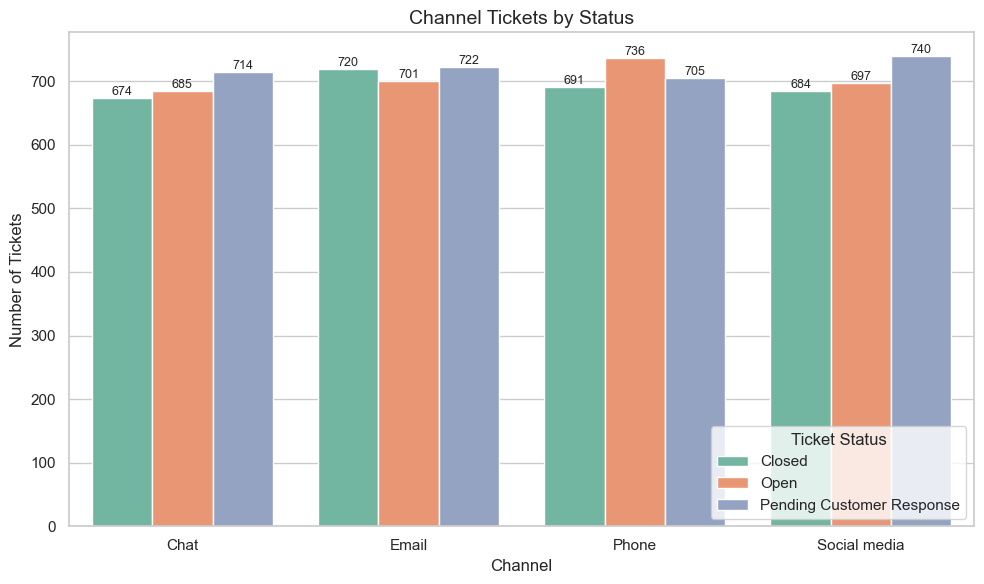

In [13]:
# Reset index so 'channel' and 'ticket_status' become columns
ticket_plot = ticket_per_channel.reset_index()

# Set plot style
sns.set(style="whitegrid")

# Create grouped bar chart
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=ticket_plot,
    x='channel',
    y='ticket_id',
    hue='ticket_status',
    palette='Set2'
)

# Add count labels on top of each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', fontsize=9)

# Title and labels
plt.title('Channel Tickets by Status', fontsize=14)
plt.xlabel('Channel')
plt.ylabel('Number of Tickets')
plt.legend(title='Ticket Status', loc='lower right')
plt.tight_layout()
plt.show()

In [ ]:
# Parsing dates

ticket_summary_df['first_response_time'] = pd.to_datetime(ticket_summary_df['first_response_time'], errors='coerce')
ticket_summary_df['time_to_resolution'] = pd.to_datetime(ticket_summary_df['time_to_resolution'], errors='coerce')
# Columns for null relationship

ticket_summary_df['not_checked_ticket'] = pd.isnull(ticket_summary_df['first_response_time'])
ticket_summary_df['not_resolved_ticket'] = pd.isnull(ticket_summary_df['time_to_resolution'])

# Filters

not_checked_tickets = ticket_summary_df[ticket_summary_df['not_checked_ticket']]
not_resolved_tickets = ticket_summary_df[ticket_summary_df['not_resolved_ticket']]
resolved_tickets = ticket_summary_df[~ticket_summary_df['not_resolved_ticket']] # Closed tickets

In [17]:
not_resolved_tickets

,ticket_id,ticket_type,ticket_subject,ticket_description,ticket_status,resolution,priority,channel,first_response_time,time_to_resolution,satisfaction_rate,not_checked_ticket,not_resolved_ticket
0,1,Technical issue,Product setup,I'm having an issue with the {product_purchase...,Pending Customer Response,NaN,Critical,Social media,2023-06-01 12:15:36,NaT,NaN,False,True
1,2,Technical issue,Peripheral compatibility,I'm having an issue with the {product_purchase...,Pending Customer Response,NaN,Critical,Chat,2023-06-01 16:45:38,NaT,NaN,False,True
5,6,Cancellation request,Payment issue,I'm facing a problem with my {product_purchase...,Open,NaN,Low,Social media,NaT,NaT,NaN,True,True
6,7,Product inquiry,Refund request,I'm unable to access my {product_purchased} ac...,Open,NaN,Critical,Social media,NaT,NaT,NaN,True,True
7,8,Refund request,Battery life,I'm having an issue with the {product_purchase...,Open,NaN,Critical,Social media,NaT,NaT,NaN,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8462,8463,Refund request,Display issue,I'm having an issue with the {product_purchase...,Pending Customer Response,NaN,Critical,Email,2023-06-02 00:36:18,NaT,NaN,False,True
8463,8464,Billing inquiry,Data loss,There seems to be a glitch in the {product_pur...,Open,NaN,Medium,Email,NaT,NaT,NaN,True,True
8464,8465,Product inquiry,Installation support,My {product_purchased} is making strange noise...,Open,NaN,Low,Phone,NaT,NaT,NaN,True,True
8465,8466,Technical issue,Refund request,I'm having an issue with the {product_purchase...,Open,NaN,Critical,Email,NaT,NaT,NaN,True,True


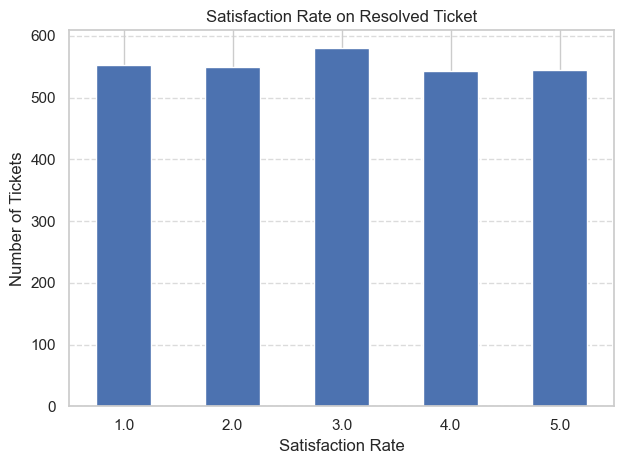

In [18]:
satisfaction_count = resolved_tickets.groupby('satisfaction_rate')['ticket_id'].count()

# Bar plot
satisfaction_count.plot(kind='bar')
plt.title('Satisfaction Rate on Resolved Ticket')
plt.ylabel('Number of Tickets')
plt.xlabel('Satisfaction Rate')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [19]:
# Re-download NLTK data
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kenny\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kenny\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [20]:
# Combine subject and description for analysis
text_data = ticket_summary_df['ticket_subject'].fillna('') + ' ' + ticket_summary_df['ticket_description'].fillna('')

# Tokenize and preprocess
tokens = word_tokenize(' '.join(text_data).lower())
tokens = [word for word in tokens if word.isalpha()]  # Remove punctuation/numbers

# Remove stopwords
stop_words = set(stopwords.words('english'))
filtered_tokens = [word for word in tokens if word not in stop_words]

# Get most common keywords
word_freq = Counter(filtered_tokens)
common_words = word_freq.most_common(10)
top_keywords_df = pd.DataFrame(common_words, columns=['Keyword', 'Frequency'])




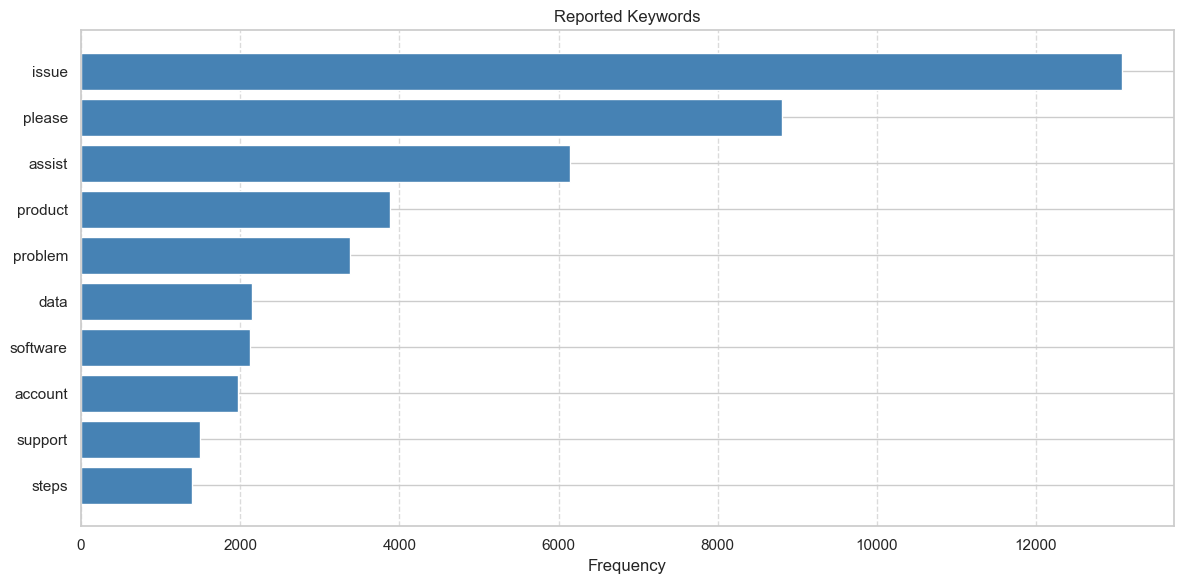

In [26]:

# Unpack keywords and their frequencies
keywords, frequencies = zip(*common_words)

# Plot configuration
plt.figure(figsize=(12, 6))
plt.barh(keywords[::-1], frequencies[::-1], color='steelblue')  # Reverse for top-down order
plt.xlabel("Frequency")
plt.title("Reported Keywords")
plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


In [22]:
ticket_summary_df['response_date'] = ticket_summary_df['first_response_time'] .dt.date
ticket_summary_df['response_time(Hours)'] = ticket_summary_df['first_response_time'].dt.hour

ticket_summary_df['resolution_date'] = ticket_summary_df['time_to_resolution'] .dt.date
ticket_summary_df['resolution_time(Hours)'] = ticket_summary_df['time_to_resolution'].dt.hour
ticket_summary_df

,ticket_id,ticket_type,ticket_subject,ticket_description,ticket_status,resolution,priority,channel,first_response_time,time_to_resolution,satisfaction_rate,not_checked_ticket,not_resolved_ticket,response_date,response_time(Hours),resolution_date,resolution_time(Hours)
0,1,Technical issue,Product setup,I'm having an issue with the {product_purchase...,Pending Customer Response,NaN,Critical,Social media,2023-06-01 12:15:36,NaT,NaN,False,True,2023-06-01,12.0,NaT,NaN
1,2,Technical issue,Peripheral compatibility,I'm having an issue with the {product_purchase...,Pending Customer Response,NaN,Critical,Chat,2023-06-01 16:45:38,NaT,NaN,False,True,2023-06-01,16.0,NaT,NaN
2,3,Technical issue,Network problem,I'm facing a problem with my {product_purchase...,Closed,Case maybe show recently my computer follow.,Low,Social media,2023-06-01 11:14:38,2023-06-01 18:05:38,3.0,False,False,2023-06-01,11.0,2023-06-01,18.0
3,4,Billing inquiry,Account access,I'm having an issue with the {product_purchase...,Closed,Try capital clearly never color toward story.,Low,Social media,2023-06-01 07:29:40,2023-06-01 01:57:40,3.0,False,False,2023-06-01,7.0,2023-06-01,1.0
4,5,Billing inquiry,Data loss,I'm having an issue with the {product_purchase...,Closed,West decision evidence bit.,Low,Email,2023-06-01 00:12:42,2023-06-01 19:53:42,1.0,False,False,2023-06-01,0.0,2023-06-01,19.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8464,8465,Product inquiry,Installation support,My {product_purchased} is making strange noise...,Open,NaN,Low,Phone,NaT,NaT,NaN,True,True,NaT,NaN,NaT,NaN
8465,8466,Technical issue,Refund request,I'm having an issue with the {product_purchase...,Open,NaN,Critical,Email,NaT,NaT,NaN,True,True,NaT,NaN,NaT,NaN
8466,8467,Technical issue,Account access,I'm having an issue with the {product_purchase...,Closed,Eight account century nature kitchen.,High,Social media,2023-06-01 09:44:22,2023-06-01 04:31:22,3.0,False,False,2023-06-01,9.0,2023-06-01,4.0
8467,8468,Product inquiry,Payment issue,I'm having an issue with the {product_purchase...,Closed,We seat culture plan.,Medium,Email,2023-06-01 18:28:24,2023-06-01 05:32:24,3.0,False,False,2023-06-01,18.0,2023-06-01,5.0


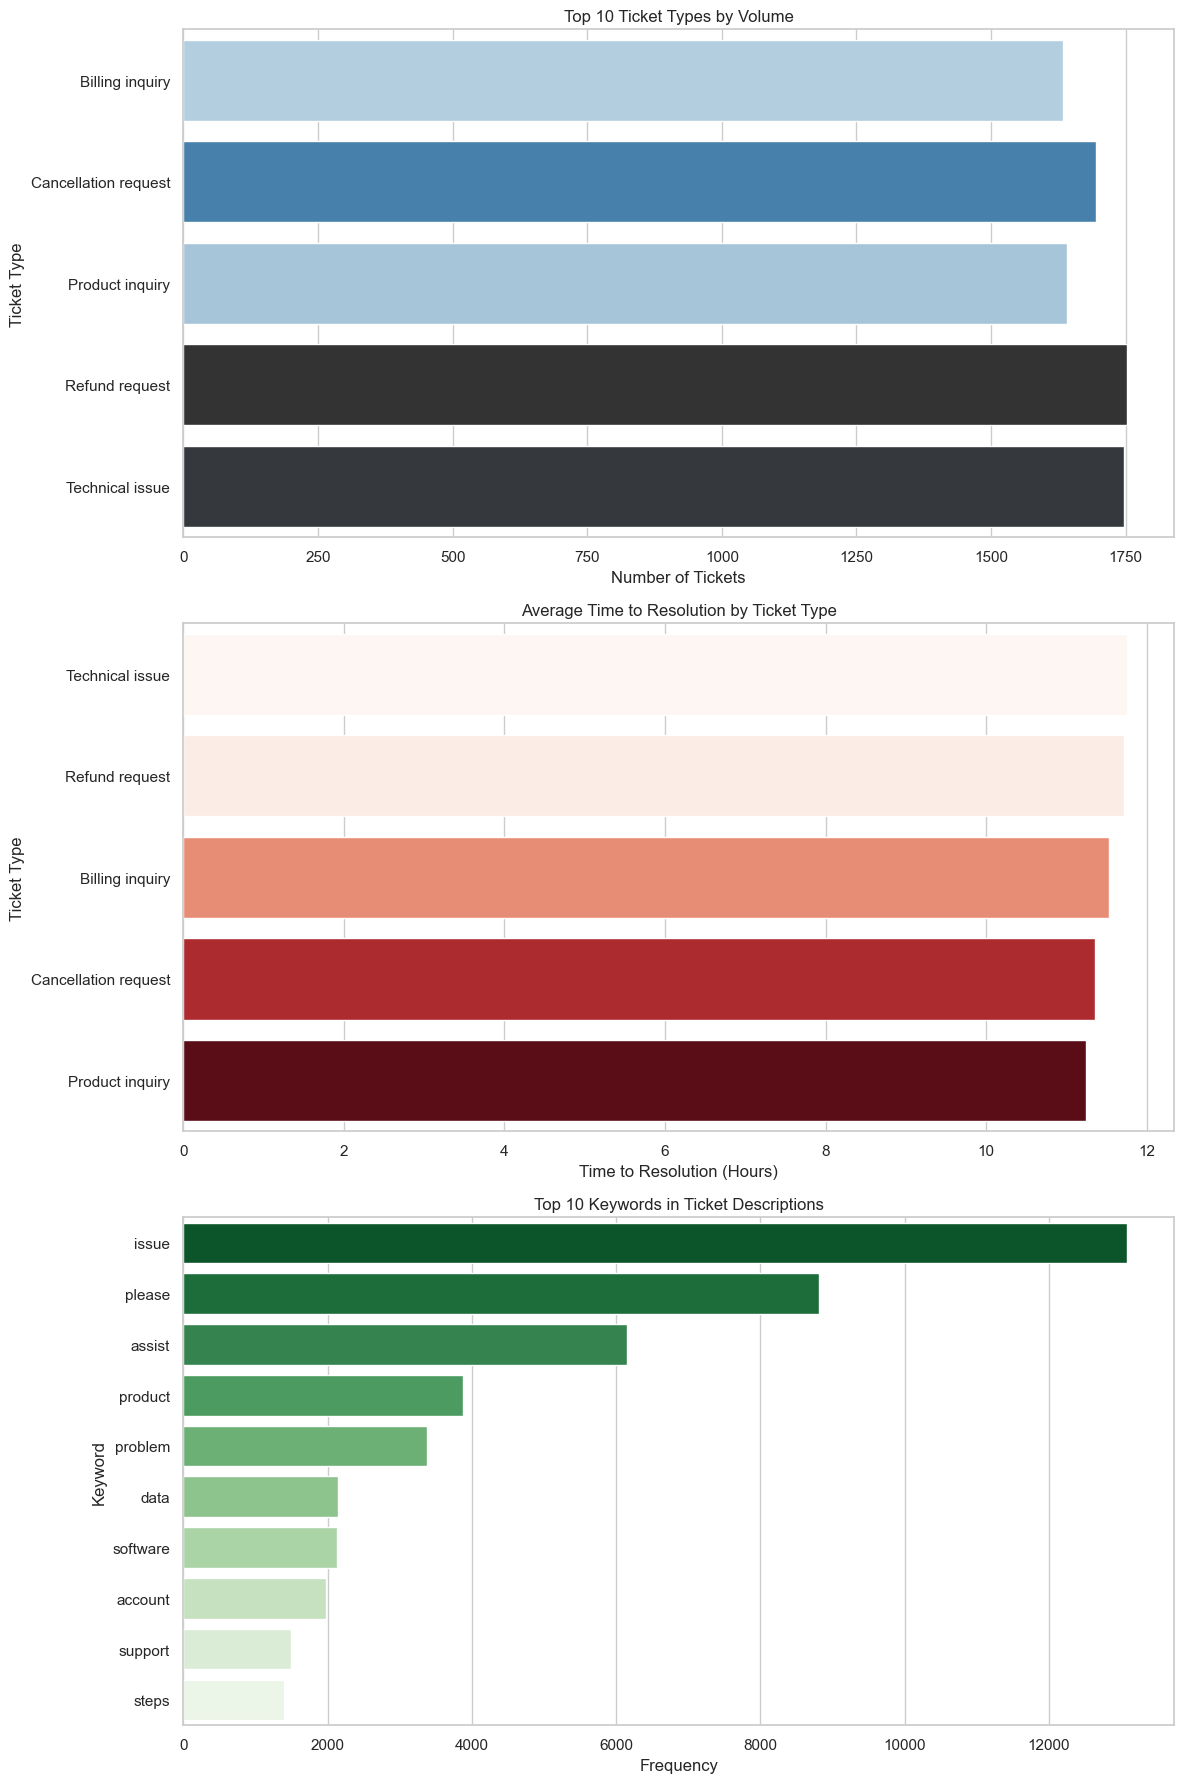

In [27]:
# 1. Ticket volume by type
ticket_type_counts = ticket_summary_df.groupby('ticket_type')['ticket_id'].count()

# 2. Average resolution time by ticket type
avg_resolution_time = ticket_summary_df.groupby('ticket_type')['response_time(Hours)'].mean().sort_values(ascending=False).head(10)

fig, axs = plt.subplots(3, 1, figsize=(12, 18))

# Plot 1: Ticket volume by type
sns.barplot(x=ticket_type_counts.values, y=ticket_type_counts.index, ax=axs[0], palette="Blues_d", hue=ticket_type_counts, legend=False)
axs[0].set_title("Top 10 Ticket Types by Volume")
axs[0].set_xlabel("Number of Tickets")
axs[0].set_ylabel("Ticket Type")

# Plot 2: Average resolution time
sns.barplot(x=avg_resolution_time.values, y=avg_resolution_time.index, ax=axs[1], palette="Reds_r", hue=avg_resolution_time, legend=False)
axs[1].set_title("Average Time to Resolution by Ticket Type")
axs[1].set_xlabel("Time to Resolution (Hours)")
axs[1].set_ylabel("Ticket Type")

# Plot 3: Top keywords
sns.barplot(x='Frequency', y='Keyword', data=top_keywords_df, ax=axs[2], palette="Greens_r",  hue='Keyword',legend=False)
axs[2].set_title("Top 10 Keywords in Ticket Descriptions")
axs[2].set_xlabel("Frequency")
axs[2].set_ylabel("Keyword")

plt.tight_layout()
plt.show()

Based on the customer support ticket data analysis specifically the ticket volumes, average resolution times, and common issue keywords—here are several actionable recommendations to improve response time and support efficiency:

## Prioritize High-Volume Ticket Types

🔍 Insight:
- Some ticket types consistently appear more frequently than others e.g., "Login Issues", "Billing Queries"

✅ Action:
- Create canned responses and automated workflows for repetitive ticket types.
- Build a self-service knowledge base for these high-volume issues.

## Optimize for Slowest-Resolved Categories

🔍 Insight:
- Certain ticket categories e.g."Technical Errors", "System Downtime" have the highest average resolution time.

✅ Action:
- Assign such tickets to specialized technical teams.
- Implement escalation rules for tickets older than a threshold e.g., 48 hours.
- Introduce ticket aging dashboards for real-time monitoring.

## Leverage Keyword Insights for Routing

🔍 Insight:
- Keyword frequency analysis (e.g., frequent words like "error", "login", "access", "payment") reveals common user frustrations.

✅ Action:
- Use natural language processing (NLP) to classify and auto-route incoming tickets based on keyword patterns.
- Train chatbot models on these keywords to handle tier-1 issues.

## Improve Agent Training Based on Common Issues

🔍 Insight:
- Common complaint categories indicate training gaps.

✅ Action:
- Develop scenario based training modules around the top 5 recurring problems.
- Share monthly trend reports with support staff.

## Automate First-Level Responses

🔍 Insight:
- Many tickets take long to receive even their first response, not just resolution.

✅ Action:
- Set up automated acknowledgments and intelligent chatbots to capture issue context before human intervention.
- Enable agents to see similar historical tickets as reference.

## Monitor KPIs and Continuous Feedback

✅ Action:
- Track KPIs:

    - Avg. Resolution Time

    - First Response Time

- Conduct monthly retrospectives to identify improvement areas.